In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import scipy as sp
#import random
import math
import os
from keras.models import Model

from numpy import mean, std
from scipy import stats
import scipy as sp

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV,  cross_val_score, RepeatedStratifiedKFold, cross_validate
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import get_scorer, make_scorer, confusion_matrix, classification_report, recall_score, precision_score, accuracy_score, fbeta_score, roc_curve, roc_auc_score, f1_score, confusion_matrix, mean_squared_error, log_loss
from sklearn import svm, datasets
from sklearn.svm import SVC
#from sklearn.naive_bayes import BernoulliNB
#from sklearn.datasets import make_classification
from sklearn.exceptions import ConvergenceWarning
from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn import svm, datasets
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler

#from scipy.stats import sem
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from numpy import load
from sklearn.decomposition import PCA

from numpy import asarray
from numpy import save

from tqdm import tqdm
import PIL
from PIL import Image, ImageOps

ModuleNotFoundError: No module named 'keras'

In [2]:
!pip install keras

  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)


In [2]:
version = 12
folder = f"/Users/julia/Downloads/QRcode12 size 65X65."

dataset_max_size = 30000

sub_folders = ("benign", "malware", "defacement", "phishing")
cnt_folders = (dataset_max_size * 3, dataset_max_size, dataset_max_size, dataset_max_size)               
cls_folders = (0, 1, 1, 1)
new_labels = ("benign", "malicious")

save_path = "/tmp/qrcode/"
filename = f"{dataset_max_size}-{version}"

if(version == 4):
    image_size = (33, 33)
    alpha = 114
elif(version == 5):
    image_size = (37, 37)
    alpha = 154
elif(version == 6):
    image_size = (41, 41)
    alpha = 195
elif(version == 12):
    image_size = (65, 65)
    alpha = 535
else:
    image_size = (36, 36)
    alpha = 130
    
#
random_state = 43021
train_sizes = [0.8]
tab = "  "
jobs = 8
n_splits = 5
ncomponentss = [50, 100, 200, 400, alpha, -1]
scores = ['accuracy'] #, 'f1']

gscv_reduction = 4000

In [3]:
#https://www.kaggle.com/datasets/samahsadiq/benign-and-malicious-qr-codes

#load the dataset

try:    
    
    #read the images
    with open(save_path + 'binary-qr-image-' + str(dataset_max_size), 'rb') as f:
        X = np.load(f)

    #read the labels
    with open(save_path + 'binary-qr-label-' + str(dataset_max_size), 'rb') as f:
        y = np.load(f)

    print(f"dataset was loaded")

except:
        
    X, y = [], []
        
    for p, sub_folder in enumerate(sub_folders):
                  
        X_subfolder, y_subfolder = [], []
            
        path = folder + "/" + sub_folder
        image_filenames = [filename for filename in os.listdir(path) if("png" in filename)]

        if(len(image_filenames) > cnt_folders[p]):        
            image_filenames = image_filenames[:cnt_folders[p]]

        for image_filename in tqdm(image_filenames, desc = "Loading " +  sub_folder, ncols = 110):

            try:
                m = Image.open(path + "/" + image_filename)

                #resize to predefined size
                m = m.resize(image_size, resample = PIL.Image.BICUBIC)

                #convert to gray scale
                m = ImageOps.grayscale(m)

                #convert to numpy array and do not rescale, save it in byte (smaller size on disk)
                n = np.array(m.getdata()).reshape(image_size[0], image_size[1], 1) / 255.0

                #append to datasets
                X_subfolder.append(n)                    
                y_subfolder.append(cls_folders[p])

            except:
                print(f"count not load: {path + '/' + image_filename}")

        #rescale
        X.extend(X_subfolder)
        y.extend(y_subfolder)

    X = np.array(X)
    y = np.array(y)
              
    try:
        #save the images
        with open(save_path + 'binary-qr-image-' + str(dataset_max_size), 'wb') as f:
            np.save(f, X)

        #save the labels
        with open(save_path + 'binary-qr-label-' + str(dataset_max_size), 'wb') as f:
            np.save(f, y)

    except:
        print("unable to save images & labels")

dataset was loaded


In [4]:
#ravel
X_global = X.reshape(dataset_max_size * 6, -1)
y_global = y.reshape(dataset_max_size * 6)

#standard scaler
sc = StandardScaler()
sc.fit_transform(X_global)
    
#select 'gscv_reduction' records from the grid searc & cross validation
sel = np.random.choice(X_global .shape[0], size = gscv_reduction, replace = False)
X_reduced = X_global[sel]
y_reduced = y_global[sel]

In [5]:
#splits train/test and performs pca
def pca_train_test_split(X, y, train_size, random_state, ncomponents):
   
    X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size = 1 - train_size, random_state = random_state)
                                           
    if(ncomponents < 0):
        X_train = X_train_
        X_test = X_test_

    else:
        pca = PCA(n_components = ncomponents)
        pca.fit(X_train_)

        X_train = pca.transform(X_train_)
        X_test = pca.transform(X_test_)
        
    return (X_train, X_test, y_train, y_test)

In [6]:
#test models with final parameters
def test_model(caption, ncomponents, train_size, random_state, model):
    
    X_train, X_test, y_train, y_test = pca_train_test_split(X_global, y_global, train_size, random_state, ncomponents)

    model = model.fit(X_train, y_train)
    y_test_pred, y_train_pred = model.predict(X_test), model.predict(X_train)

    # report the scores
    score_train, score_test = model.score(X_train, y_train), model.score(X_test, y_test)
    f1_test, f1_train = f1_score(y_test, y_test_pred, average = 'macro'), f1_score(y_train, y_train_pred, average = 'macro')
    log_loss_train, log_loss_test = log_loss(y_train, y_train_pred), log_loss(y_test, y_test_pred)   
    rmse_train, rmse_test = math.sqrt(mean_squared_error(y_train, y_train_pred)), math.sqrt(mean_squared_error(y_test, y_test_pred)) #, multioutput='raw_values' 


    print(tab * 6 + "train accuracy score", score_train)
    print(tab * 6 + "test accuracy score", score_test)  

#   print(tab * 6 + "train f1 score", f1_train)
#   print(tab * 6 + "test f1 score", f1_test) 
        
#   print(tab * 6 + "log loss train", log_loss_train)
#   print(tab * 6 + "log loss test", log_loss_test)
    
    print(tab * 6 + "rmse_train", rmse_train)
    print(tab * 6 + "rmse_test", rmse_test)
          
    plt.bar(["train", "test"], [score_train, score_test], color = ['red', 'blue'], width = 0.4)
    plt.ylabel("Accuracy")
    plt.title("accuracy train/test comparison")
    plt.savefig(save_path + caption + "-best-train-test-accuracy.png")
    plt.show()
          
    plt.bar(["train", "test"], [log_loss_train, log_loss_test], color = ['pink', 'turquoise'], width = 0.4)
    plt.ylabel("log loss")
    plt.title("loss train/test comparison")
    plt.savefig(save_path + caption + "-best-train-test-loss.png")
    plt.show()

In [7]:
#create dataframe with specific columns
def result_dataframe():
    return pd.DataFrame(columns = ["score","train score", "test score", 
                                  "test rmse", "train rmse", "test log_loss",
                                  "train log_loss","PCA n-components", "test size", 
                                  "random state","estimator params", "estimator"])

#adds a record to the dataframe
def results_add(results, estimator, grid_best_score_, score_train, score_test, rmse_test, rmse_train, log_loss_test, log_loss_train, ncomponents, train_size, random_state, grid_best_params_):
    
    n = len(results)
    results.at[n, 'score']            = grid_best_score_
    results.at[n, 'train score']      = score_train
    results.at[n, 'test score']       = score_test

    results.at[n, 'test rmse']        = rmse_test
    results.at[n, 'train rmse']       = rmse_train

    results.at[n, 'test log_loss']    = log_loss_test
    results.at[n, 'train log_loss']   = log_loss_train

    results.at[n, 'PCA n-components'] = ncomponents
    results.at[n, 'test size']        = 1 - train_size
    results.at[n, 'random state']     = random_state
    results.at[n, 'estimator params'] = grid_best_params_
    results.at[n, 'estimator']        = estimator
    
    # report the best configuration
    print(tab * 6 + "Best score: %f using %s" % (grid_best_score_, grid_best_params_))

    print(tab * 6 + "train score", score_train)
    print(tab * 6 + "test  score", score_test)

    print(tab * 6 + "log loss train", log_loss_train)
    print(tab * 6 + "log loss test", log_loss_test)

    print(tab * 6 + "rmse_train", rmse_train)
    print(tab * 6 + "rmse_test", rmse_test)


In [8]:
#LogisticRegression grid search and cross validation
lr_results = result_dataframe()

# Define params for classifier LR
grid_params_lr = [ {'clf__C'            : [0.001, 1, 1.5],
                    'clf__solver'       : ['liblinear', 'saga', 'lbfgs',],
                    'clf__max_iter'     : [600],
                     }]

cls_params = [(LogisticRegression(), grid_params_lr),] 

for train_size in train_sizes:
    
    print(tab * 1 + f"train size: {train_size}")
    for ncomponents in ncomponentss:
        print(tab * 2 + f"PCA ncomponents: {ncomponents}")                  
        X_train, X_test, y_train, y_test = pca_train_test_split(X_reduced, y_reduced, train_size, random_state, ncomponents)

        # Run Grid search for each classifier
        for classifier, grid_params in cls_params: 
            
            classifier_type = type(classifier)
            print(tab * 4 + f"{classifier_type}")
            
            pipeline = Pipeline(steps = [('clf', classifier)])        
            cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = jobs, random_state = random_state)

            # define grid search
            for score in scores:
                print(tab * 5 + f"score: {score}")

                grid = GridSearchCV(pipeline, param_grid = grid_params, scoring = score, cv = cv, n_jobs = jobs)
                grid = grid.fit(X_train, y_train)
                y_test_pred, y_train_pred = grid.predict(X_test), grid.predict(X_train)
                
                score_train = grid.score(X_train, y_train)
                score_test  = grid.score(X_test, y_test)                
                log_loss_train, log_loss_test = log_loss(y_train, y_train_pred), log_loss(y_test, y_test_pred)                   
                rmse_train, rmse_test = math.sqrt(mean_squared_error(y_train, y_train_pred)), math.sqrt(mean_squared_error(y_test, y_test_pred)) 
                    
                results_add(lr_results, "LR gscv", grid.best_score_, score_train, score_test, rmse_test, rmse_train, log_loss_test, log_loss_train, ncomponents, train_size, random_state, grid.best_params_)                

lr_results.to_csv(save_path + filename + "LR-gscv.csv")

  train size: 0.8
    PCA ncomponents: 50
        <class 'sklearn.linear_model._logistic.LogisticRegression'>
          score: accuracy
            Best score: 0.769141 using {'clf__C': 1, 'clf__max_iter': 600, 'clf__solver': 'liblinear'}
            train score 0.8046875
            test  score 0.7375
            log loss train 6.745920981293182
            log loss test 9.066563735730401
            rmse_train 0.4419417382415922
            rmse_test 0.51234753829798
    PCA ncomponents: 100
        <class 'sklearn.linear_model._logistic.LogisticRegression'>
          score: accuracy
            Best score: 0.758008 using {'clf__C': 1, 'clf__max_iter': 600, 'clf__solver': 'liblinear'}
            train score 0.86875
            test  score 0.775
            log loss train 4.5332568804455065
            log loss test 7.771334633501556
            rmse_train 0.362284418654736
            rmse_test 0.4743416490252569
    PCA ncomponents: 200
        <class 'sklearn.linear_model._logisti

/Users/yaeerk/Documents/NAYA/python/python-env/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


            Best score: 0.746875 using {'clf__C': 1, 'clf__max_iter': 600, 'clf__solver': 'saga'}
            train score 1.0
            test  score 0.73125
            log loss train 9.992007221626413e-16
            log loss test 9.28243608568253
            rmse_train 0.0
            rmse_test 0.518411033833193
    PCA ncomponents: 535
        <class 'sklearn.linear_model._logistic.LogisticRegression'>
          score: accuracy
            Best score: 0.776758 using {'clf__C': 1, 'clf__max_iter': 600, 'clf__solver': 'saga'}
            train score 1.0
            test  score 0.76875
            log loss train 9.992007221626413e-16
            log loss test 7.987206983453686
            rmse_train 0.0
            rmse_test 0.48088460154178364
    PCA ncomponents: -1
        <class 'sklearn.linear_model._logistic.LogisticRegression'>
          score: accuracy
            Best score: 0.785352 using {'clf__C': 1, 'clf__max_iter': 600, 'clf__solver': 'saga'}
            train score 1.0


/Users/yaeerk/Documents/NAYA/python/python-env/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


            train accuracy score 0.8585347222222223
            test accuracy score 0.8586666666666667
            rmse_train 0.37611870171234213
            rmse_test 0.3759432581299116


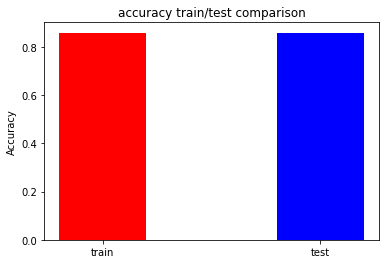

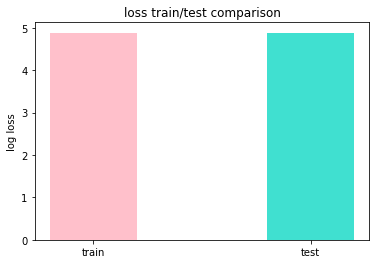

In [9]:
#Accuracy:  0.822188 using {'clf__C': 0.001, 'clf__max_iter': 600, 'clf__solver': 'lbfgs'}
test_model("LR", 535, 0.8, random_state, LogisticRegression(C = 0.001, solver = 'lbfgs', max_iter = 600))

In [10]:
#DecisionTree grid search and cross validation
dt_results = result_dataframe()

# Define params for classifier 
grid_params_dt = [ {'clf__min_samples_leaf' : [2, 4, 8, 16, 32, 64],}]
cls_params = [(DecisionTreeClassifier(), grid_params_dt),]

for train_size in train_sizes:
    print(tab * 1 + f"train size: {train_size}")
    
    for ncomponents in ncomponentss:
        print(tab * 2 + f" PCA ncomponents: {ncomponents}")    
        X_train, X_test, y_train, y_test = pca_train_test_split(X_reduced, y_reduced, train_size, random_state, ncomponents)

        # Run Grid search for each classifier
        for classifier, grid_params in cls_params: 
            
            classifier_type = type(classifier)
            print(tab * 4 + f"{classifier_type}")
            pipeline = Pipeline(steps = [('clf', classifier)])        
            cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = jobs, random_state = 1)

            # define grid search
            for score in scores:
                print(tab * 5 + f"score: {score}")

                grid = GridSearchCV(pipeline, param_grid = grid_params, scoring = score, cv = cv, n_jobs = jobs)
                grid = grid.fit(X_train, y_train)
                y_test_pred, y_train_pred = grid.predict(X_test), grid.predict(X_train)

                score_train = grid.score(X_train, y_train)
                score_test  = grid.score(X_test, y_test)                
                log_loss_train, log_loss_test = log_loss(y_train, y_train_pred), log_loss(y_test, y_test_pred)   
                rmse_train, rmse_test = math.sqrt(mean_squared_error(y_train, y_train_pred)), math.sqrt(mean_squared_error(y_test, y_test_pred)) 
                    
                results_add(dt_results, "DT gscv", grid.best_score_, score_train, score_test, rmse_test, rmse_train, log_loss_test, log_loss_train, ncomponents, train_size, random_state, grid.best_params_)                

dt_results.to_csv(save_path + filename + "DT-gscv.csv")

  train size: 0.8
     PCA ncomponents: 50
        <class 'sklearn.tree._classes.DecisionTreeClassifier'>
          score: accuracy
            Best score: 0.741016 using {'clf__min_samples_leaf': 32}
            train score 0.8046875
            test  score 0.70625
            log loss train 6.745934724374012
            log loss test 10.145875510651665
            rmse_train 0.4419417382415922
            rmse_test 0.54198708471697
     PCA ncomponents: 100
        <class 'sklearn.tree._classes.DecisionTreeClassifier'>
          score: accuracy
            Best score: 0.731250 using {'clf__min_samples_leaf': 64}
            train score 0.7921875
            test  score 0.7
            log loss train 7.177698164843044
            log loss test 10.361772848023488
            rmse_train 0.45586456322026175
            rmse_test 0.5477225575051661
     PCA ncomponents: 200
        <class 'sklearn.tree._classes.DecisionTreeClassifier'>
          score: accuracy
            Best score: 0.7

            train accuracy score 0.9450347222222222
            test accuracy score 0.9363611111111111
            rmse_train 0.23444674827725331
            rmse_test 0.25226749471322873


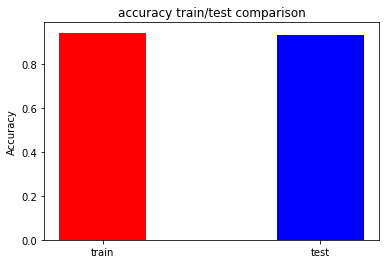

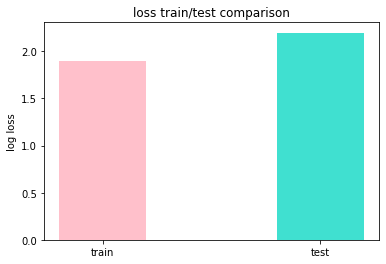

In [11]:
#Accuracy Best score: 0.868320 using {'clf__min_samples_leaf': 32}
test_model("DT", -1, 0.8, random_state, DecisionTreeClassifier(min_samples_leaf = 32))

In [12]:
#SVC grid search and cross validation
svc_results = result_dataframe()

# Define params for  classifier SVC                   
grid_params_svc = [ {'clf__kernel'       : ['linear', 'rbf','sigmoid'],
                     'clf__C'            : [0.001, 1, 1.5],
                     'clf__max_iter'     : [2000],
                     }]

cls_params = [(SVC(), grid_params_svc),] 

for train_size in train_sizes:
    print(tab * 1 + f"train size: {train_size}")

    for ncomponents in ncomponentss:
        print(tab * 2 + f"PCA ncomponents: {ncomponents}")
        X_train, X_test, y_train, y_test = pca_train_test_split(X_reduced, y_reduced, train_size, random_state, ncomponents)
                                           
        # Run Grid search for each classifier
        for classifier, grid_params in cls_params: 
            
            classifier_type = type(classifier)
            print(tab * 4 + f"{classifier_type}")
            pipeline = Pipeline(steps = [('clf', classifier)])        
            cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = jobs, random_state = 1)

            # define grid search
            for score in scores:
                print(tab * 5 + f"score: {score}")

                grid = GridSearchCV(pipeline, param_grid = grid_params, scoring = score, cv = cv, n_jobs = jobs)
                grid = grid.fit(X_train, y_train)
                y_test_pred, y_train_pred = grid.predict(X_test), grid.predict(X_train)

                score_train = grid.score(X_train, y_train)
                score_test  = grid.score(X_test, y_test)
                log_loss_train, log_loss_test = log_loss(y_train, y_train_pred), log_loss(y_test, y_test_pred)   
                rmse_train, rmse_test = math.sqrt(mean_squared_error(y_train, y_train_pred)), math.sqrt(mean_squared_error(y_test, y_test_pred)) 
                    
                results_add(svc_results, "SVC gscv", grid.best_score_, score_train, score_test, rmse_test, rmse_train, log_loss_test, log_loss_train, ncomponents, train_size, random_state, grid.best_params_)                

svc_results.to_csv(save_path + filename + "LR-gscv.csv")

  train size: 0.8
    PCA ncomponents: 50
        <class 'sklearn.svm._classes.SVC'>
          score: accuracy
            Best score: 0.776563 using {'clf__C': 1.5, 'clf__kernel': 'rbf', 'clf__max_iter': 2000}
            train score 0.8203125
            test  score 0.81875
            log loss train 6.206228862073993
            log loss test 6.260218188868764
            rmse_train 0.42389562394532926
            rmse_test 0.42573465914816
    PCA ncomponents: 100
        <class 'sklearn.svm._classes.SVC'>
          score: accuracy
            Best score: 0.782813 using {'clf__C': 1.5, 'clf__kernel': 'sigmoid', 'clf__max_iter': 2000}
            train score 0.803125
            test  score 0.75625
            log loss train 6.799895315636137
            log loss test 8.418946685874008
            rmse_train 0.4437059837324712
            rmse_test 0.49371044145328746
    PCA ncomponents: 200
        <class 'sklearn.svm._classes.SVC'>
          score: accuracy
            Best score

/Users/yaeerk/Documents/NAYA/python/python-env/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


            Best score: 0.773828 using {'clf__C': 1, 'clf__kernel': 'linear', 'clf__max_iter': 2000}
            train score 1.0
            test  score 0.7375
            log loss train 9.992007221626413e-16
            log loss test 9.066568733214337
            rmse_train 0.0
            rmse_test 0.51234753829798


/Users/yaeerk/Documents/NAYA/python/python-env/lib/python3.6/site-packages/sklearn/svm/_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


            train accuracy score 0.5035972222222223
            test accuracy score 0.5011944444444445
            rmse_train 0.7045585694445692
            rmse_test 0.7062616764029856


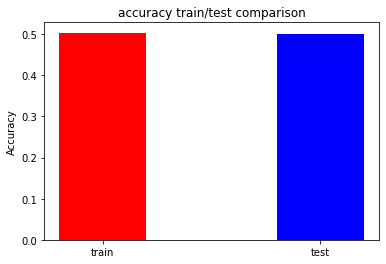

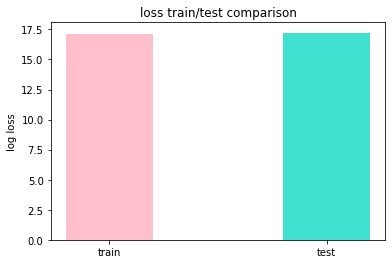

In [13]:
#Accuracy Best score: 0.842227 using {'clf__C': 1.5, 'clf__kernel': 'rbf', 'clf__max_iter': 2000}
test_model("SVC", 400, 0.8, random_state, SVC(C = 1.5, kernel = "rbf", max_iter = 2000))